### Bayesian inference for gaussian distribution with known scale

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Normal
import matplotlib.pyplot as plt

(array([  1.,   0.,   1.,   4.,   8.,  23.,  28.,  31.,  56.,  60.,  70.,
         67.,  57.,  32.,  28.,  21.,   7.,   2.,   3.,   1.]),
 array([ 1.20606256,  1.56109217,  1.91612179,  2.27115141,  2.62618103,
         2.98121065,  3.33624027,  3.69126989,  4.04629951,  4.40132912,
         4.75635874,  5.11138836,  5.46641798,  5.8214476 ,  6.17647722,
         6.53150684,  6.88653646,  7.24156607,  7.59659569,  7.95162531,
         8.30665493]),
 <a list of 20 Patch objects>)

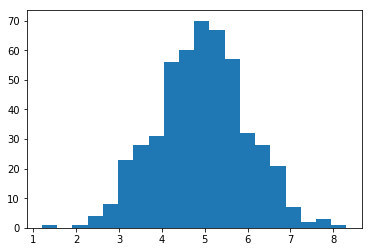

In [2]:
# Generate sample data
N = 500
mu = 5.0
scale = 1.0
data = np.random.normal(loc=mu, scale=scale, size=N).astype(np.float32)
plt.hist(data, bins=20)

In [3]:
# Prior for mu
mu_0 = 1.0
scale_0 = 1.0
mu = Normal(loc=tf.zeros(1) * mu_0, scale=tf.ones(1) * scale_0)

# Generative model
x = Normal(loc=tf.ones(N) * mu, scale=tf.ones(N) * scale)

# Posterior distribution to be estimated
qmu_mu = tf.Variable([0.0])
qmu_scale= tf.nn.softplus(tf.Variable([0.0]))
qmu = Normal(loc=qmu_mu, scale=qmu_scale)

# Setup inference
inference = ed.KLqp({mu: qmu}, data={x: data})
inference.initialize()
tf.global_variables_initializer().run()
sess = ed.get_session()

# Run inference
n_iter = 20000
trace = np.zeros((n_iter, 2))
for t in xrange(n_iter):
    # run one iteration
    inference.update()
    # extract posterior parameters and write to trace
    trace[t, :] = sess.run([qmu_mu, qmu_scale])

In [4]:
# Posterior for gaussian with known scale is known
# See: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
prec = 1.0 / (scale**2)
prec_0 = 1.0 / (scale_0**2)
mu_MLE = np.mean(data)
prec_N = prec_0 + N * prec
w = N * prec / prec_N
mu_N = w * mu_MLE + (1.0 - w) * mu_0
scale_N = np.sqrt(1. / prec_N)
qmu_true = Normal(loc=tf.ones(1) * mu_N, scale=tf.ones(1) * scale_N)

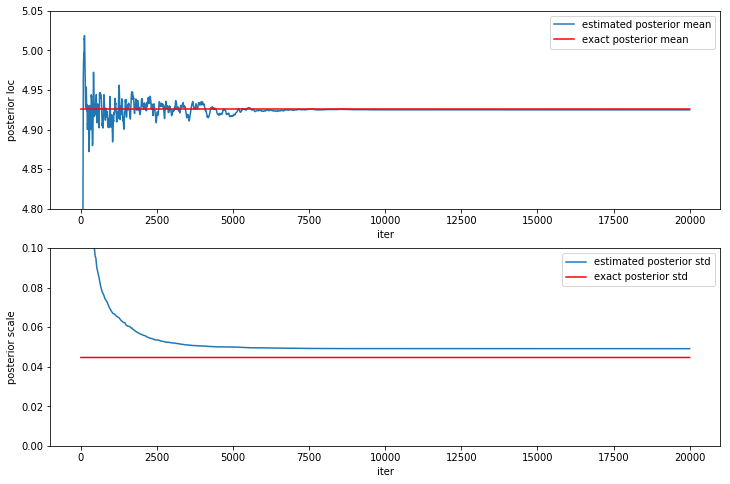

In [5]:
# Plot results

fh, [ax0, ax1] = plt.subplots(2, 1, figsize=(12, 8))
ax0_line0, = ax0.plot(trace[:, 0], label='estimated posterior mean')
ax0_line1, = ax0.plot(range(n_iter), np.ones(n_iter) * mu_N, '-r', label='exact posterior mean')
ax0.set_ylim(4.8, 5.05)
ax0.set_xlabel('iter')
ax0.set_ylabel('posterior loc')
ax0.legend(handles=[ax0_line0, ax0_line1])

ax1_line0, = ax1.plot(trace[:, 1], label='estimated posterior std')
ax1_line1, = ax1.plot(range(n_iter), np.ones(n_iter) * scale_N, '-r', label='exact posterior std')
ax1.set_ylim(0.0, 0.1)
ax1.set_xlabel('iter')
ax1.set_ylabel('posterior scale')
ax1.legend(handles=[ax1_line0, ax1_line1])